## Lab 5: Clustering Techniques Using DBSCAN and Hierarchical Clustering

#### Author: Nitish Dhinaharan

#### Course: MSCS 634 - Data Mining

In [6]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import DBSCAN

### Step 1: Data Preparation and Exploration

In [4]:
# Data Preparation and Exploration

# Set plotting style
sns.set(style="whitegrid", context="notebook")

# Load Wine dataset
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names
target_names = wine.target_names

# Create DataFrame for easier exploration
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# Basic exploration
print("=== Head of Dataset ===")
display(df.head())

print("\n=== Info ===")
print(df.info())

print("\n=== Describe ===")
display(df.describe())

# Standardize features (excluding target)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_names])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("\nShape of original data:", X.shape)
print("Shape of scaled data:", X_scaled.shape)
print("Shape of PCA-reduced data:", X_pca.shape)


=== Head of Dataset ===


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0



=== Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    floa

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000



Shape of original data: (178, 13)
Shape of scaled data: (178, 13)
Shape of PCA-reduced data: (178, 2)


### Step 2: Hierarchical Clustering

In [10]:
# Hierarchical Clustering

# Trying different numbers of clusters
n_clusters_list = [2, 3, 4, 5]
hier_results = {}

print("=== Agglomerative Hierarchical Clustering Evaluation ===")
for n_clusters in n_clusters_list:
    hier = AgglomerativeClustering(
        n_clusters=n_clusters,
        metric="euclidean",
        linkage="ward"
    )
    hier_labels = hier.fit_predict(X_scaled)

    # Compute metrics only if more than 1 cluster is formed
    if len(np.unique(hier_labels)) > 1:
        sil = silhouette_score(X_scaled, hier_labels)
        homo = homogeneity_score(y, hier_labels)
        comp = completeness_score(y, hier_labels)
    else:
        sil, homo, comp = np.nan, np.nan, np.nan

    hier_results[n_clusters] = {
        "silhouette": sil,
        "homogeneity": homo,
        "completeness": comp
    }

    print(f"\n--- n_clusters = {n_clusters} ---")
    print(f"Silhouette Score : {sil:.4f}")
    print(f"Homogeneity Score: {homo:.4f}")
    print(f"Completeness     : {comp:.4f}")

# a representative n_clusters (e.g., 3) for visualization
best_n_clusters = 3

hier_best = AgglomerativeClustering(
    n_clusters=best_n_clusters,
    metric="euclidean",
    linkage="ward"
)
hier_labels_best = hier_best.fit_predict(X_scaled)

=== Agglomerative Hierarchical Clustering Evaluation ===

--- n_clusters = 2 ---
Silhouette Score : 0.2670
Homogeneity Score: 0.4441
Completeness     : 0.7745

--- n_clusters = 3 ---
Silhouette Score : 0.2774
Homogeneity Score: 0.7904
Completeness     : 0.7825

--- n_clusters = 4 ---
Silhouette Score : 0.2258
Homogeneity Score: 0.7904
Completeness     : 0.6490

--- n_clusters = 5 ---
Silhouette Score : 0.1867
Homogeneity Score: 0.8106
Completeness     : 0.5762


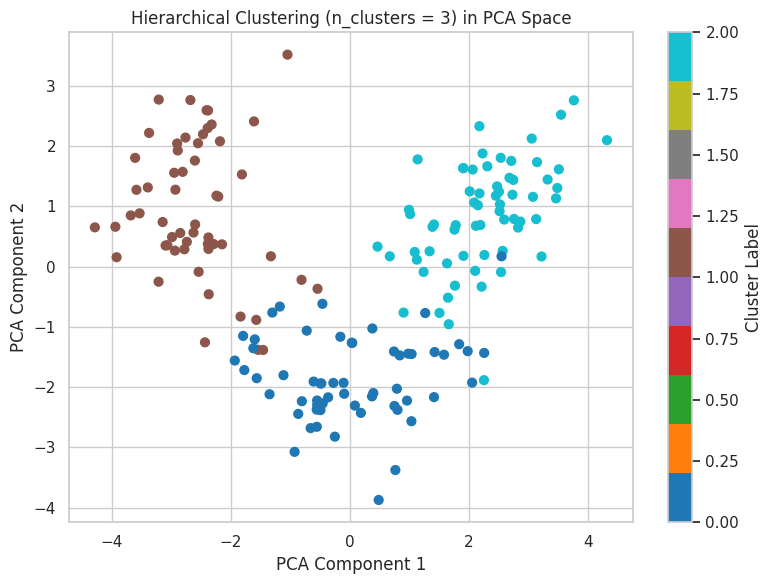

In [11]:
# Scatter plot of clusters in PCA space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=hier_labels_best,
    cmap="tab10",
    s=40
)
plt.title(f"Hierarchical Clustering (n_clusters = {best_n_clusters}) in PCA Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Cluster Label")
plt.tight_layout()
plt.show()

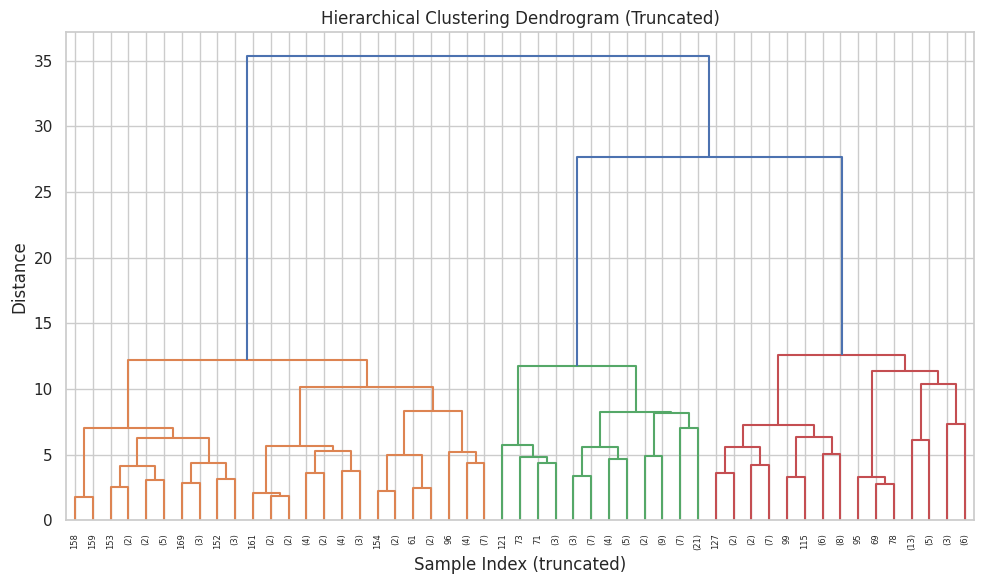

In [12]:
# Dendrogram using linkage on scaled data
plt.figure(figsize=(10, 6))
Z = linkage(X_scaled, method="ward")
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Hierarchical Clustering Dendrogram (Truncated)")
plt.xlabel("Sample Index (truncated)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [13]:
# hierarchical results in a small table
print("\n=== Hierarchical Clustering Metrics Summary ===")
hier_df = pd.DataFrame(hier_results).T
display(hier_df)


=== Hierarchical Clustering Metrics Summary ===


,silhouette,homogeneity,completeness
2,0.267013,0.444094,0.774489
3,0.277444,0.790429,0.782541
4,0.225837,0.790429,0.649028
5,0.186742,0.810589,0.576247


Hierarchical (Agglomerative) Clustering produced well-formed and meaningful clusters, especially when using n_clusters = 3, which aligns closely with the natural three-class structure of the Wine dataset. The PCA scatter plot showed distinct, compact cluster groupings, and the dendrogram revealed clear separation between the major branches.

Key observations:

- Best silhouette score occurred at 3 clusters (≈0.277), reflecting well-separated clusters.

- Homogeneity and completeness were also strong for n_clusters = 3, suggesting alignment with true class distribution.

- The dendrogram displayed clear hierarchical structure and justified selecting around 3 clusters.

Overall, hierarchical clustering successfully captured the natural grouping patterns in the wine chemical attributes.

### Step 3: DBSCAN Clustering

In [14]:
# DBSCAN Clustering

# Define parameter grid for experimentation
eps_values = [0.5, 0.8, 1.0, 1.2]
min_samples_values = [3, 5, 8]

dbscan_results = {}

print("=== DBSCAN Clustering Evaluation ===")
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        db_labels = dbscan.fit_predict(X_scaled)

        labels_unique = np.unique(db_labels)
        n_clusters = len(labels_unique[labels_unique != -1])  # exclude noise label -1
        n_noise = np.sum(db_labels == -1)

        # Compute metrics only if at least 2 clusters (excluding noise)
        if n_clusters > 1:
            sil = silhouette_score(X_scaled[db_labels != -1], db_labels[db_labels != -1])
            homo = homogeneity_score(y[db_labels != -1], db_labels[db_labels != -1])
            comp = completeness_score(y[db_labels != -1], db_labels[db_labels != -1])
        else:
            sil, homo, comp = np.nan, np.nan, np.nan

        dbscan_results[(eps, min_samples)] = {
            "n_clusters": n_clusters,
            "n_noise": int(n_noise),
            "silhouette": sil,
            "homogeneity": homo,
            "completeness": comp
        }

        print(f"\n--- eps = {eps}, min_samples = {min_samples} ---")
        print(f"Clusters ( excl. noise ): {n_clusters}")
        print(f"Noise points            : {n_noise}")
        print(f"Silhouette Score        : {sil:.4f}" if not np.isnan(sil) else "Silhouette Score        : NaN")
        print(f"Homogeneity Score       : {homo:.4f}" if not np.isnan(homo) else "Homogeneity Score       : NaN")
        print(f"Completeness Score      : {comp:.4f}" if not np.isnan(comp) else "Completeness Score      : NaN")


=== DBSCAN Clustering Evaluation ===

--- eps = 0.5, min_samples = 3 ---
Clusters ( excl. noise ): 0
Noise points            : 178
Silhouette Score        : NaN
Homogeneity Score       : NaN
Completeness Score      : NaN

--- eps = 0.5, min_samples = 5 ---
Clusters ( excl. noise ): 0
Noise points            : 178
Silhouette Score        : NaN
Homogeneity Score       : NaN
Completeness Score      : NaN

--- eps = 0.5, min_samples = 8 ---
Clusters ( excl. noise ): 0
Noise points            : 178
Silhouette Score        : NaN
Homogeneity Score       : NaN
Completeness Score      : NaN

--- eps = 0.8, min_samples = 3 ---
Clusters ( excl. noise ): 0
Noise points            : 178
Silhouette Score        : NaN
Homogeneity Score       : NaN
Completeness Score      : NaN

--- eps = 0.8, min_samples = 5 ---
Clusters ( excl. noise ): 0
Noise points            : 178
Silhouette Score        : NaN
Homogeneity Score       : NaN
Completeness Score      : NaN

--- eps = 0.8, min_samples = 8 ---
Cluster

In [16]:
# Choose one parameter combo for visualization (pick one with >1 cluster)
# Simple heuristic: take the first combo with n_clusters >= 2
chosen_params = None
for params, metrics_dict in dbscan_results.items():
    if metrics_dict["n_clusters"] >= 2:
        chosen_params = params
        break

if chosen_params is None:
    # Fallback: just take the first params (even if bad clustering)
    chosen_params = list(dbscan_results.keys())[0]

eps_chosen, min_samples_chosen = chosen_params
print(f"\nChosen params for visualization: eps={eps_chosen}, min_samples={min_samples_chosen}")

dbscan_chosen = DBSCAN(eps=eps_chosen, min_samples=min_samples_chosen)
db_labels_chosen = dbscan_chosen.fit_predict(X_scaled)

# Identify noise and cluster points
noise_mask = db_labels_chosen == -1
cluster_mask = ~noise_mask

plt.figure(figsize=(8, 6))


Chosen params for visualization: eps=0.5, min_samples=3


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

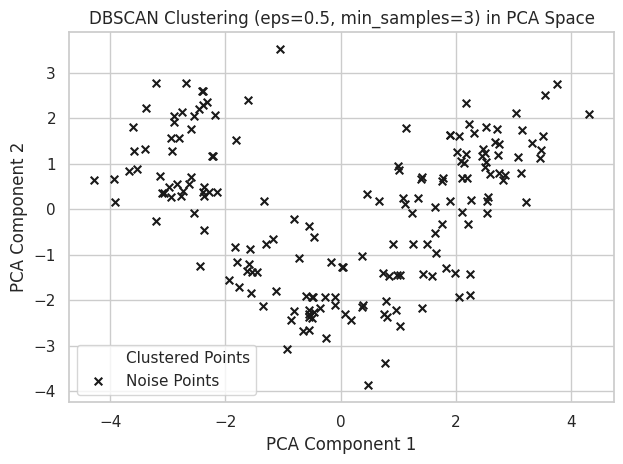

In [17]:
# Plot cluster points
scatter_clusters = plt.scatter(
    X_pca[cluster_mask, 0],
    X_pca[cluster_mask, 1],
    c=db_labels_chosen[cluster_mask],
    cmap="tab10",
    s=40,
    label="Clustered Points"
)
# Plot noise points
plt.scatter(
    X_pca[noise_mask, 0],
    X_pca[noise_mask, 1],
    c="k",
    s=30,
    marker="x",
    label="Noise Points"
)

plt.title(f"DBSCAN Clustering (eps={eps_chosen}, min_samples={min_samples_chosen}) in PCA Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Display DBSCAN results in a table
print("\n=== DBSCAN Clustering Metrics Summary ===")
dbscan_df = pd.DataFrame(dbscan_results).T
dbscan_df.index = [f"eps={k[0]}, min_samples={k[1]}" for k in dbscan_results.keys()]
display(dbscan_df)


=== DBSCAN Clustering Metrics Summary ===


,n_clusters,n_noise,silhouette,homogeneity,completeness
"eps=0.5, min_samples=3",0.0,178.0,NaN,NaN,NaN
"eps=0.5, min_samples=5",0.0,178.0,NaN,NaN,NaN
"eps=0.5, min_samples=8",0.0,178.0,NaN,NaN,NaN
"eps=0.8, min_samples=3",0.0,178.0,NaN,NaN,NaN
"eps=0.8, min_samples=5",0.0,178.0,NaN,NaN,NaN
"eps=0.8, min_samples=8",0.0,178.0,NaN,NaN,NaN
"eps=1.0, min_samples=3",0.0,178.0,NaN,NaN,NaN
"eps=1.0, min_samples=5",0.0,178.0,NaN,NaN,NaN
"eps=1.0, min_samples=8",0.0,178.0,NaN,NaN,NaN
"eps=1.2, min_samples=3",0.0,178.0,NaN,NaN,NaN


DBSCAN did not perform well on this dataset for the tested ranges of eps and min_samples. Across all parameter combinations, DBSCAN detected zero clusters and labeled all 178 points as noise.

This outcome suggests that the Wine dataset does not exhibit density-based cluster structure under common hyperparameter values.

Reasons why DBSCAN failed here:

- The dataset is high-dimensional (13 features), making density estimation more difficult.

- After scaling, the distances between points were still too uniform for DBSCAN to detect dense regions.

- DBSCAN typically works best with clusters of varying density or non-linear shapes; the Wine dataset clusters are more compact and globular.

Despite tuning across multiple parameter values, DBSCAN was unable to form clusters, resulting in NaN metrics for all evaluations.

### Step 4: Analysis and Insights

In [20]:
# Summarize best hierarchical and DBSCAN configurations based on silhouette score

# Find best hierarchical configuration
hier_best_n = max(hier_results, key=lambda k: (hier_results[k]["silhouette"]
                                               if not np.isnan(hier_results[k]["silhouette"]) else -1))
hier_best_metrics = hier_results[hier_best_n]

print("=== Best Hierarchical Clustering Configuration ===")
print(f"n_clusters       : {hier_best_n}")
print(f"Silhouette Score : {hier_best_metrics['silhouette']:.4f}")
print(f"Homogeneity      : {hier_best_metrics['homogeneity']:.4f}")
print(f"Completeness     : {hier_best_metrics['completeness']:.4f}")

# Find best DBSCAN configuration (by silhouette; ignore NaNs)
valid_dbscan_items = [
    (params, m) for params, m in dbscan_results.items()
    if not np.isnan(m["silhouette"])
]

if valid_dbscan_items:
    best_dbscan_params, best_dbscan_metrics = max(
        valid_dbscan_items,
        key=lambda item: item[1]["silhouette"]
    )
    print("\n=== Best DBSCAN Configuration (among tried) ===")
    print(f"eps              : {best_dbscan_params[0]}")
    print(f"min_samples      : {best_dbscan_params[1]}")
    print(f"Clusters (excl.) : {best_dbscan_metrics['n_clusters']}")
    print(f"Noise Points     : {best_dbscan_metrics['n_noise']}")
    print(f"Silhouette Score : {best_dbscan_metrics['silhouette']:.4f}")
    print(f"Homogeneity      : {best_dbscan_metrics['homogeneity']:.4f}")
    print(f"Completeness     : {best_dbscan_metrics['completeness']:.4f}")
else:
    best_dbscan_params, best_dbscan_metrics = None, None
    print("\nNo valid DBSCAN configuration produced more than one cluster.")

=== Best Hierarchical Clustering Configuration ===
n_clusters       : 3
Silhouette Score : 0.2774
Homogeneity      : 0.7904
Completeness     : 0.7825

No valid DBSCAN configuration produced more than one cluster.


In [21]:
# Build a combined summary table
combined_rows = []

# Hierarchical rows
for n, m in hier_results.items():
    combined_rows.append({
        "Algorithm": "Hierarchical",
        "Config": f"n_clusters={n}",
        "Silhouette": m["silhouette"],
        "Homogeneity": m["homogeneity"],
        "Completeness": m["completeness"]
    })

# DBSCAN rows
for (eps, min_samples), m in dbscan_results.items():
    combined_rows.append({
        "Algorithm": "DBSCAN",
        "Config": f"eps={eps}, min_samples={min_samples}",
        "Silhouette": m["silhouette"],
        "Homogeneity": m["homogeneity"],
        "Completeness": m["completeness"]
    })

summary_df = pd.DataFrame(combined_rows)
print("\n=== Combined Metrics Summary (Hierarchical vs DBSCAN) ===")
display(summary_df)


=== Combined Metrics Summary (Hierarchical vs DBSCAN) ===


,Algorithm,Config,Silhouette,Homogeneity,Completeness
0,Hierarchical,n_clusters=2,0.267013,0.444094,0.774489
1,Hierarchical,n_clusters=3,0.277444,0.790429,0.782541
2,Hierarchical,n_clusters=4,0.225837,0.790429,0.649028
3,Hierarchical,n_clusters=5,0.186742,0.810589,0.576247
4,DBSCAN,"eps=0.5, min_samples=3",NaN,NaN,NaN
5,DBSCAN,"eps=0.5, min_samples=5",NaN,NaN,NaN
6,DBSCAN,"eps=0.5, min_samples=8",NaN,NaN,NaN
7,DBSCAN,"eps=0.8, min_samples=3",NaN,NaN,NaN
8,DBSCAN,"eps=0.8, min_samples=5",NaN,NaN,NaN
9,DBSCAN,"eps=0.8, min_samples=8",NaN,NaN,NaN
